## Integrate L-Py with xarray-simlab

https://xarray-simlab.readthedocs.io

### Write Lpy file and save it

In [7]:
%%writefile .lpydevel.lpy

import matplotlib.pyplot as plt
import matplotlib as mpl

color = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=10), cmap=plt.cm.hsv)

#################################

from numpy import exp, linspace, nan
growth_logistic = lambda ttime, fsize: fsize / (1. + exp(-(ttime-5)/1.5 ))

#################################

extern(flush_delay = None)
extern(nb_metamers = None)
extern(step_delta = None)

#################################

module Metamer(t, parent, targetsize, lighting)
module Apex(t, lastmetamer)

#################################

Axiom:  R Apex(0, nan)

derivation length: 1
production:

Apex(t, lm) :
    if (t % flush_delay) < step_delta and (t // flush_delay) < nb_metamers:
        p = MetamerParams(t=0, targetsize=0, parent=lm, lighting=0)
        lm = p.uid        
        nproduce Metamer(p)
    produce Apex(t+step_delta, lm)

Metamer(p):
    p.t += step_delta
    p.targetsize = growth_logistic(p.t, 10)
    produce Metamer(p)
    
interpretation:

R --> _(0.3)@Gc SetColor(Material('green',(1,15,1),diffuse=10,specular=(0,0,0)))

Metamer(p) :
    l = p.targetsize
    r, g, b, a = map(lambda v : int(v*255), color.to_rgba(p.lighting))
    nproduce F(l/3) /(137)[SetColor(r, g, b)_(0.1)&(min(80,float(p.t)*5))F(l/6)[+(90)/(-30)~l(l/2)][-(90)/(30)~l(l/2)]F(l/6)[+(60)/(-15)~l(l/2)][-(60)/(15)~l(l/2)]F(l/6)^(20)~l(l/2)]

Apex(t,lm) --> F(1) @O


Writing .lpydevel.lpy


In [8]:
import xsimlab as xs
from lpy_simlab_process import xs_lpyprocess

xs_lpyprocess('LpyDevel', '.lpydevel.lpy', modulestoconsider=['Metamer'], 
              {'Metamer_lighting' : xs.global_ref('Metamer_lighting', intent='in')} )


lpy_simlab_process.LpyDevel

In [9]:
import numpy as np

@xs.process
class Light():

   
    # process input
    Metamer = xs.foreign(LpyDevel, 'Metamer')
    lscene = xs.foreign(LpyDevel, 'lscene')
    
    #leaf_opt_properties = xs.variable()
   
    # process output
    Metamer_lighting = xs.variable(dims='Metamer', global_name='Metamer_lighting', intent='inout')
    
    def initialize(self):
        self.Metamer_lighting = np.zeros(len(self.Metamer))
    
    @xs.runtime()
    def run_step(self):
        from openalea.plantgl.light import diffuseInterception
        res = diffuseInterception(lscene)
        self.Metamer_lighting = np.array([res[i] for i in range(len(self.Metamer))])



### Create an xarray-simlab processes from an Lpy model

* __LpyDevel__, build lstring and scene and access computed variables 

### Create xarray-simlab model and simulation setup with the two processes

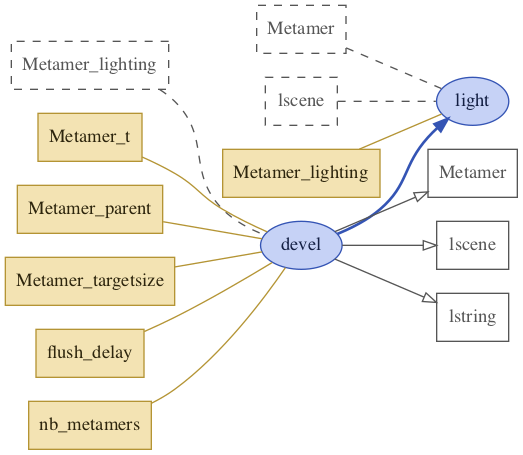

In [11]:
import numpy as np

model = xs.Model({ 'devel': LpyDevel  , 'light' : Light  }) # , 'carbon' : Carbon  })
ds = xs.create_setup(
    model=model,
    clocks={ 'time': np.linspace(0, 25, 250) },
    input_vars={ 'devel': { 'flush_delay' : 4, 'nb_metamers' : 5 } },
    output_vars={
        'devel__Metamer_targetsize': 'time',
    }
)
model.visualize(show_inputs=True, show_variables=True)

### Run the model and inspect results

In [6]:
from lpy_simlab_process import xs_lpydisplay_hook

ds_out = ds.xsimlab.run(model=model, hooks=xs_lpydisplay_hook('devel', scales = 1/30))
ds_out

SceneWidget(scenes=[{'id': 'KxupXs3foj1JMCr1yEGtgoSD8', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

KeyError: "Missing variables ['devel__Metamer_t', 'devel__Metamer_parent', 'devel__Metamer_targetsize', 'light__Metamer_lighting'] in Dataset"

### Plot output

In [ ]:
ds_out.devel__Metamer_leaf_size.plot.line(x='time');

## Carbon allocation

In [10]:
tip = 5
b = 1.5
fsize = 10
def growth_rate(ttime): 
    expt = exp(-(ttime-tip)/b)
    return fsize * expt / b* (1. + expt)**2

@xs.process
class CarbonAllocation():


    # process input
    Metamer_t = xs.foreign(LpyDevel, 'Metamer_t')
    Metamer_parent = xs.foreign(LpyDevel, 'Metamer_parent')
    
    Metamer_lighting = xs.foreign(Light, 'Metamer_lighting')
    
    # process output
    Metamer_carbon = xs.variable(dims='Metamer', intent='inout')
    Metamer_demand = xs.variable(dims='Metamer', intent='inout')
    
    def initialize(self):
        self.Metamer_carbon = np.zeros((len(self.Metamer),))
    
    @xs.runtime()
    def run_step(self):
        nb_metamers = len(self.Metamer)
        
        self.adjacency = np.zeros((nb_metamers,nb_metamers))
        hasparent = isnan(self.Metamer_parent)== False
        mparent = self.Metamer_parent[hasnoparent]
        self.adjacency[(np.where(hasparent), mparent)] = 1
        
        self.distances = csgraph.shortest_path(self.adjacency, directed=False).astype(np.float32)
        
        self.carbon = self.Metamer_lighting * conv_rate
        
        self.demand = growth_rate(Metamer_t)
        
        self.allocated = min(self.carbon, self.demand)
        
        self.demand -= self.allocated
        self.carbon -= self.allocated
        
        
